# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


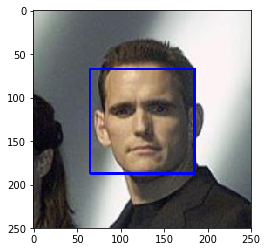

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

from IPython.display import Markdown

## DONE: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def pct_faces(files):
    images_with_faces = 0
    for file in files:
        if face_detector(file):
            images_with_faces += 1
    
    return images_with_faces / len(files) * 100

display(Markdown(
    "> __Answer 1:__\n\n"+
    "> |Humans images |Dogs images.\n"+
    "> -:|:-|:-\n"+
    "> Human face detected|{:.0f}%|{:.0f}%".format(pct_faces(human_files_short), pct_faces(dog_files_short))
))

> __Answer 1:__

> |Humans images |Dogs images.
> -:|:-|:-
> Human face detected|97%|11%

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer 2:__

Since its fully possible to get a lot better human recognition than utilizing the haar cascade face detection, I'd say the fully developed app should do that, but it will be a judgement call if its important enough to spend more time on. The dog detector detected different dog breeds using known pretrained weights on the ResNet50 architecture. I made a quick look to see if any of the classes represented humans, but I only found animal labels in the output. It would had been a quick modification to simply use the already trained weights on an predefined architecture and spotted the humans.

For this app, I'd suggest to have one single network responsible for classifying humans and dogs and its breeds. The dog outcome should be the sum of all the dog breeds (using "softmax" activation).

__Otional task:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer 3:__ 

In [11]:
### DONE: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def pct_dogs(files):
    images_with_dogs = 0
    for file in files:
        if dog_detector(file):
            images_with_dogs += 1
    
    return images_with_dogs / len(files) * 100

display(Markdown(
    "> __Answer 3:__\n\n"+
    "> |Human images|Dogs images\n"+
    "> -:|:-|:-\n"+
    "> Dog detected|{:.0f}%|{:.0f}%".format(pct_dogs(human_files_short), pct_dogs(dog_files_short))
))

> __Answer 3:__

> |Human images|Dogs images
> -:|:-|:-
> Dog detected|2%|100%

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:03<00:00, 214.98it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer 4:__

First I wanted to verify my own understanding of the parts involved, I raised questions.

* Why did the first convolutional layer in the provided example architecture output a shape with 223 rather than 224? --- `valid` padding vs `same` padding.
* How do I slowly deform the shape of my input to match the onedimensional output layer? --- `MaxPooling2D` layers or `Conv2D` layers with stride larger than 1.
* GPU vs CPU time on training the provided architecture for 5 epochs (GeForce GTX 1080 Ti vs Intel i7 7700K)? --- 29 sec (7%) vs 400 sec.

---

Secondly I started experimenting with the hinted architecture, looking at the training, validation and testing accuracy change, always using 10 epochs.

* What happens if I add or remove convolutional layers in the same manner? --- It did better for two additional layers, then it started overfitting.

Model|Time (s)|Train acc.|Val acc.|Test acc.|Out. width|Params|Notes
-:|-|-|-|-|-|-|:-
Suggested CNN - 2 Conv|44|1.87%|1.68%|2.03%|111|2,469|
Suggested CNN - 1 Conv|54|2.10%|2.04%|1.44%|55|6,677|
Suggested CNN         |60|3.05%|2.75%|3.59%|27|19,189|
Suggested CNN + 1 Conv|63|6.50%|5.15%|7.18%|13|60,597|
Suggested CNN + 2 Conv|66|9.55%|6.71%|10.5%|6|208,949|Wow!
Suggested CNN + 3 Conv|68|20.7%|15.6%|2.03%|2|772,429|Overfitting!

* What happens if I add some more dense layers in the end? --- It improves without much additional training time if I add two but no more than two layers for a total of three dense layers in the end. But is this significant, the same architecture that previously gave me a testing score of 10.5% now gave me 7.18%...

Model|Time (s)|Train acc.|Val acc.|Test acc.|Out. width|Params|Notes
-:|-|-|-|-|-|-|:-
Suggested CNN + 2 Conv               |65|7.35%|6.35%|7.18%|6|208,949|A lot worse than before!?
Suggested CNN + 2 Conv + 1 Dense 128 |66|7.46%|7.76%|8.13%|6|224,821|Slightly better?
Suggested CNN + 2 Conv + 2 Dense 128 |67|8.56%|7.78%|9.09%|6|241,333|Slightly better?
Suggested CNN + 2 Conv + 3 Dense 128 |66|5.76%|5.55%|6.58%|6|257,845|Worse?

* Using the same architecture, I noticed I got quite different outcomes of training. How much variation is there really? --- Okay the variation is too high to conclude that my additional dense layers previously was beneficial...

Model|Time (s)|Train acc.|Val acc.|Test acc.|Out. width|Params|Notes
-:|-|-|-|-|-|-|:-
Suggested CNN + 2 Conv|66|9.55%|6.71%|10.5%|6|208,949|
Suggested CNN + 2 Conv|65|7.35%|6.35%|7.18%|6|208,949|Worst run
Suggested CNN + 2 Conv|66|11.1%|8.38%|11.0%|6|208,949|Best run
Suggested CNN + 2 Conv|65|9.40%|7.43%|10.8%|6|208,949|
Suggested CNN + 2 Conv|65|11.3%|8.14%|9.68%|6|208,949|

* So if I make five runs with two additional dense layers, will I improve on average? --- No I don't think so, at least not using only 10 epochs.

Model|Time (s)|Train acc.|Val acc.|Test acc.|Out. width|Params
-:|-|-|-|-|
Suggested CNN + 2 Conv + 2 Dense 128 |67|8.56%|7.78%|9.09%|6|241,333
Suggested CNN + 2 Conv + 2 Dense 128 |67|7.77%|6.47%|8.37%|6|241,333
Suggested CNN + 2 Conv + 2 Dense 128 |66|6.83%|5.75%|8.49%|6|241,333
Suggested CNN + 2 Conv + 2 Dense 128 |66|8.25%|7.78%|9.21%|6|241,333
Suggested CNN + 2 Conv + 2 Dense 128 |67|8.02%|7.19%|9.57%|6|241,333

* So if I let my two most interesting candidates architecture run for 50 epochs, how good do they get? --- They reach about 20% then it keeps overfitting without improving.

Model|Time (s)|Train acc.|Val acc.|Test acc.|Out. width|Params|Epochs|Last acc.|Notes
-:|-|-|-|-|-|-|-|-|:-
Suggested CNN + 2 Conv               |5m28s|48.9%|23.7%|23.2%|6|208,949|50 (best at 35)|70.2%|Overfitting
Suggested CNN + 2 Conv + 2 Dense 128 |5m31s|32%|20.2%|21.5%|6|241,333|50 (best at 28)|76.5%|Overfitting

---

I'll stop experimenting with the hinted architecture now and settle to use a similar architecture of the hinted one, where I add two convolutional and pooling layers. I like that it massages the input dimensions down as suggested by the course video below.

|__CNNs For Image Classification__|
|:-|
|[![](https://img.youtube.com/vi/l9vg_1YUlzg/0.jpg)](https://www.youtube.com/watch?v=l9vg_1YUlzg&t=5m25s)|

---

> __REFINEMENT ATTEMPT 1__: I returned here and experimented further using Dropout and BatchNormalization layers, but I never got better results by using them. The variation in my final architecture was quite big, I managed to get 33% once, but the median test result was probably around 20-22%.

> __REFINEMENT ATTEMPT 2__: I experimented using a dense layer in the end with 512 nodes and dropout of 0.2 as well as batch normalization, and found that my training became more steady - loss and val_loss went down together without diverging from eachother. I also managed to get about the same result as before, so that became my final model!

In [69]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

# I decided on 5 Conv2D+MaxPooling2D pairs, I tried more, I tried less...
# Using multiple Dropout layers never worked out for me...
# Using one or multiple BatchNormalization also never worked out for me.
# I added a Dropout+Dense layer before the output layer, that might
# and might not have improved my architecture, it's hard to tell.

model = Sequential()

#model.add(Dropout(0.2, input_shape=(224,224,3)))
model.add(Conv2D(16, (2,2), strides=(1,1), padding='valid', input_shape=(224,224,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.2))
model.add(Conv2D(32, (2,2), strides=(1,1), padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.2))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.2))
model.add(Conv2D(128, (2,2), strides=(1,1), padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.2))
model.add(Conv2D(256, (2,2), strides=(1,1), padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.2))
#model.add(Conv2D(256, (2,2), strides=(1,1), padding='valid', activation='relu'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

# This pair of Dropout / Dense layers caused loss and val_loss to go down hand in
# hand a lot better during training. It felt better and gives a slight improvement.
model.add(Dropout(0.2))
model.add(Dense(512))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='relu'))

model.add(Dense(133))
#model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
activation_98 (Activation)   (None, 223, 223, 16)      0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
activation_99 (Activation)   (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 54, 54, 64)        8256      
__________

### Compile the Model

In [70]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [71]:
%%time
from keras.callbacks import ModelCheckpoint

# avoid retraining on notebook re-run
if (True):
    ### DONE: specify the number of epochs that you would like to use to train the model.
    epochs = 40

    ### Do NOT modify the code below this line.
    checkpointer = ModelCheckpoint(filepath='saved_models/final_weights.best.from_scratch.hdf5', 
                                   verbose=1, save_best_only=True)

    model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 7s - loss: 4.8840 - acc: 0.0081 - val_loss: 4.8705 - val_acc: 0.0084
Epoch 2/40
6680/6680 [==============================] - 6s - loss: 4.8726 - acc: 0.0112 - val_loss: 4.8628 - val_acc: 0.0120
Epoch 3/40
6680/6680 [==============================] - 6s - loss: 4.7813 - acc: 0.0181 - val_loss: 4.6831 - val_acc: 0.0287
Epoch 4/40
6680/6680 [==============================] - 6s - loss: 4.6316 - acc: 0.0310 - val_loss: 4.6106 - val_acc: 0.0371
Epoch 5/40
6680/6680 [==============================] - 6s - loss: 4.4835 - acc: 0.0442 - val_loss: 4.4279 - val_acc: 0.0371
Epoch 6/40
6680/6680 [==============================] - 6s - loss: 4.3485 - acc: 0.0464 - val_loss: 4.3416 - val_acc: 0.0527
Epoch 7/40
6680/6680 [==============================] - 6s - loss: 4.2487 - acc: 0.0542 - val_loss: 4.3608 - val_acc: 0.0431
Epoch 8/40
6680/6680 [==============================] - 6s - loss: 4.1641 - ac

6680/6680 [==============================] - 7s - loss: 2.5573 - acc: 0.3160 - val_loss: 3.1947 - val_acc: 0.2180
Epoch 29/40
6680/6680 [==============================] - 6s - loss: 2.4722 - acc: 0.3349 - val_loss: 3.4010 - val_acc: 0.1964
Epoch 30/40
6680/6680 [==============================] - 6s - loss: 2.4077 - acc: 0.3490 - val_loss: 3.2345 - val_acc: 0.2263
Epoch 31/40
6680/6680 [==============================] - 6s - loss: 2.3455 - acc: 0.3587 - val_loss: 3.2566 - val_acc: 0.2347
Epoch 32/40
6680/6680 [==============================] - 6s - loss: 2.2760 - acc: 0.3760 - val_loss: 3.1854 - val_acc: 0.2299
Epoch 33/40
6680/6680 [==============================] - 6s - loss: 2.2032 - acc: 0.3919 - val_loss: 3.1479 - val_acc: 0.2431
Epoch 34/40
6680/6680 [==============================] - 6s - loss: 2.1545 - acc: 0.3975 - val_loss: 3.1569 - val_acc: 0.2419
Epoch 35/40
6680/6680 [==============================] - 6s - loss: 2.0588 - acc: 0.4305 - val_loss: 3.0887 - val_acc: 0.2527
Epoc

### Load the Model with the Best Validation Loss

In [75]:
model.load_weights('saved_models/final_weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [76]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# The accuracy is varying a lot with each training. The best training run got 33%.

Test accuracy: 24.4019%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/final_weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 0s - loss: 12.2286 - acc: 0.1180 - val_loss: 10.6560 - val_acc: 0.2180
Epoch 2/20
6680/6680 [==============================] - 0s - loss: 9.9717 - acc: 0.2843 - val_loss: 10.0313 - val_acc: 0.2707
Epoch 3/20
6680/6680 [==============================] - 0s - loss: 9.5242 - acc: 0.3472 - val_loss: 9.9192 - val_acc: 0.3126
Epoch 4/20
6680/6680 [==============================] - 0s - loss: 9.3270 - acc: 0.3765 - val_loss: 9.8068 - val_acc: 0.3090
Epoch 5/20
6680/6680 [==============================] - 0s - loss: 9.2279 - acc: 0.3946 - val_loss: 9.7765 - val_acc: 0.3222
Epoch 6/20
6680/6680 [==============================] - 0s - loss: 9.1509 - acc: 0.4067 - val_loss: 9.7808 - val_acc: 0.3246
Epoch 7/20
6680/6680 [==============================] - 0s - loss: 8.9632 - acc: 0.4187 - val_loss: 9.6095 - val_acc: 0.3413
Epoch 8/20
6680/6680 [==============================] - 0s - loss: 8.8437 -

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/final_weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.0622%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
arch = ['VGG16', 'VGG19', 'Resnet50', 'InceptionV3', 'Xception'][4]

In [26]:
### DONE: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/Dog' + arch + 'Data.npz')
train_chosen_arch = bottleneck_features['train']
valid_chosen_arch = bottleneck_features['valid']
test_chosen_arch = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer 5:__ 

#### Comparison of models

I tried transfer learning on all the architectures, and found that the VGG networks were a lot worse, but the others were similar in performance. I ended up choosing to use the InceptionV3 model instead of Xception with the best performance though, because it Xception tended to classify humans as a specific dog breed all the time, which wasn't amusing enough.

Architecture 1|Input filters|Total params*|Training time|Train acc.\**|Val acc.\**|Best test acc.|Best epoch
-|-|-|-|-|-|-
VGG16|512|68k|13|41%|35%|35%|20
VGG19|512|68k|13|58%|48%|47%|20
ResNet50|2048|273k|17|96% (100%)|82% (81%)|80%|5
InceptionV3|2048|273k|21|86% (99%)|83% (84%)|80%|2
Xception|2048|273k|28|90% (98%)|85% (86%)|84%|3

\* Among the transfer learning layers of the architecture, not the full model.

\*\* Values in parenthesis represents accuracy after all training epochs - not necessarily the state of the model with the lowest validation loss.

#### Improving the transfer learning architecture

* I tried adding one additional dense layer, as suggested in [this instruction video](https://www.youtube.com/watch?v=LHG5FltaR6I&t=2m29s) with the remark "... then we can add __one or two more__, and train only the final layer.". - This did not yield better test scores.

* I experimented using Dropout layers to combat overfitting, but that didn't seem to help significantly, it rather seemed to make it worse.

* POST REVIEW UPDATE: I added one single batch normalization layer in between the activation and the Dense layer and got slightly better results! 84% test acc. became 86%.

#### Why did VGG16/19 performed noticably worse than ResNet/Inception/Xception?

* Idea 1: The output from the VGG models (VGG16, VGG19) were 512 compared to 2048 for the other architectures (ResNet50, InceptionV3, Xception). Apparently it was easier to find relevant output to identify dogs in the latter architectures - they could potentially convey more detailed information about the picture. *Building on more knowledge yielded better results.*
* Idea 2: The quality of the output from the models vary in quality for the task for classifying dogs, the output is after all generated from different architectures and that is influencing how well they were trained. Perhaps ResNet50, InceptionV3 and Xception was better trained due to their architecture, data augmentation or epoch count etc? *Building on higher quality yields better results.*

In [27]:
### DONE: Define your architecture.
chosen_arch_model = Sequential()
chosen_arch_model.add(GlobalAveragePooling2D(input_shape=train_chosen_arch.shape[1:]))
chosen_arch_model.add(Dense(133))
chosen_arch_model.add(BatchNormalization()) # POST REVIEW UPDATE: BatchNormalization indeed helped!
chosen_arch_model.add(Activation('softmax'))

chosen_arch_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
_________________________________________________________________
batch_normalization_1 (Batch (None, 133)               532       
_________________________________________________________________
activation_56 (Activation)   (None, 133)               0         
Total params: 273,049
Trainable params: 272,783
Non-trainable params: 266
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [28]:
### DONE: Compile the model.
chosen_arch_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
%%time
### DONE: Train the model.
# avoid retraining on notebook re-run
if (True):
    checkpointer = ModelCheckpoint(filepath='saved_models/final_weights.best.' + arch + '.hdf5', 
                                   verbose=1, save_best_only=True)

    chosen_arch_model.fit(train_chosen_arch, train_targets, 
              validation_data=(valid_chosen_arch, valid_targets),
              epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 2.3898 - acc: 0.6395 - val_loss: 0.9399 - val_acc: 0.7964
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 1.8131 - acc: 0.7777 - val_loss: 0.8166 - val_acc: 0.8287
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 1.5870 - acc: 0.8148 - val_loss: 0.7658 - val_acc: 0.8335
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 1.4129 - acc: 0.8335 - val_loss: 0.7165 - val_acc: 0.8311
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 1.2556 - acc: 0.8557 - val_loss: 0.6906 - val_acc: 0.8503
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 1.1222 - acc: 0.8681 - val_loss: 0.6662 - val_acc: 0.8419
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 1.0029 - acc: 0.8795 - val_loss: 0.6807 - val_acc: 0.8371
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.9135 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [73]:
### DONE: Load the model weights with the best validation loss.
chosen_arch_model.load_weights('saved_models/final_weights.best.' + arch + '.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [74]:
### DONE: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
chosen_arch_predictions = [np.argmax(chosen_arch_model.predict(np.expand_dims(feature, axis=0))) for feature in test_chosen_arch]

# report test accuracy
test_accuracy = 100*np.sum(np.array(chosen_arch_predictions)==np.argmax(test_targets, axis=1))/len(chosen_arch_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 86.0048%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen_arch CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen_arch CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [32]:
### DONE: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import extract_bottleneck_features

extract_chosen_arch = getattr(extract_bottleneck_features, 'extract_' + arch)

def find_dog_breed_images(dog_breed, path='dogImages/valid'):
    """Returns image paths for a given dog breed."""
    for root, dirs, files in os.walk(path):
        for d in dirs:
            if fnmatch.fnmatch(d, '???.'+dog_breed):
                dog_breed_path = os.path.join(root, d)
                _, _, dog_breed_images = os.walk(dog_breed_path).__next__()
                
                return [os.path.join(dog_breed_path, img) for img in dog_breed_images]

def chosen_arch_predict_breeds(img_path, top=5):
    """Returns a list of tuples representing the top predicted breeds: (breed, confidence, breed_img_paths)"""
    
    # extract bottleneck features
    bottleneck_feature = extract_chosen_arch(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = chosen_arch_model.predict(bottleneck_feature)
    
    # get the top predictions
    top_indices = reversed(predicted_vector.argsort()[0][-top:])
    
    return [(dog_names[i], predicted_vector[0][i], find_dog_breed_images(dog_names[i])) for i in top_indices]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [33]:
import os

### DONE: Write your algorithm.
def dog_analyzer(img_path):
    """Looks for dogs and humans in a provided image and suggest
    what dog breed is matching the dog or person best."""
    
    if not os.path.isfile(img_path):
        raise FileNotFoundError(img_path)
    
    is_dog = dog_detector(img_path)
    is_human = face_detector(img_path)
    kind = None
    breed = None
    
    if is_dog:
        kind = 'dog'
    elif is_human:
        kind = 'human'
    else:
        kind = 'unknown'
    
    breed, confidence, breed_img_path = chosen_arch_predict_breeds(img_path)[0]
    
    return kind, breed, confidence, img_path, breed_img_path

In [34]:
from IPython.display import Markdown, HTML
import fnmatch

def dog_analyzer_pretty(img_paths):
    imgs = [dog_analyzer(img_path) for img_path in img_paths]
    
    for i, img in enumerate(imgs):
        kind, breed, confidence, provided_img, dog_breed_imgs = img
                
        display(HTML("""
        <table width="100%">
            <thead>
                <tr>
                    <th colspan="2" width="50%" style="text-align:left">Input - A photo of a: {} (?)</th>
                    <th colspan="2" width="50%" style="text-align:left">Output - Dog breed prediction: {} ({:.2f}% confidence)</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td colspan="2" width="50%" style="text-align:left"><img width="100%" src="{}"></td>
                    <td colspan="2" width="50%" style="text-align:left"><img width="100%" src="{}"></td>
                </tr>
            </tbody>
        </table>
        """.format(kind, breed, confidence*100, provided_img, dog_breed_imgs[0]))) #, *dog_breed_imgs
        # I gave four additional examples of the predicted dog breed, it was simply too much...
        #<!--<tr>
        #    <td width="25%" style="text-align:left"><img width="100%" src="{}"></td>
        #    <td width="25%" style="text-align:left"><img width="100%" src="{}"></td>
        #    <td width="25%" style="text-align:left"><img width="100%" src="{}"></td>
        #    <td width="25%" style="text-align:left"><img width="100%" src="{}"></td>
        #</tr>-->

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer 6:__

#### Summary
My model is based on InceptionV3, it was retrofitted for dog breed classification with transfer learning without modifying any of the weights of InceptionV3 model. It works quite well but the outcome often changes in between trainings - the extend of this variation surprised me and disappointed me a bit. But otherwise it performed similarly to my expectations.

#### What you will see below
* four pictures of dogs
* two pictures of me
* three pictures of other animals (koala, bear, alpaca)

#### Observations
* The `dog_dector` (ResNet50) dog or not classification worked great on all pictures and wasn't fooled by other animals.
* The human classification (based on human face detection) was tried on the six non-dog pictures made a mistake on the alpaca and believed (because it perceived the lamas face as a human face).
* The confidence on the dog classifier was very high on the dogs in comparison to all other pictures.
* Training can yield quite different outcomes in performance (81%-85%) on the test set and on my own input images.
* Sometimes the model seemingly ends up to favor one kind of breed a lot when I give it images of something else entirely.

#### Suggested improvements
> NOTE: To me, it is obvious what kind of improvements are asked for in the question, so I decided on focusing on improvements surrounding ML rather than the user experience.

* The fine tune training overfitted the network greatly, reaching very high training accuracy while the validation and test accuracy were a lot lower. This caused a lot of the later epochs to be pointless, as the overfitting never yielded a better model. Perhaps I could add a dropout layer or similar to combat this?
* The `face_detector` is used to determine if it is a human - this is too simple. Humans should be detected no matter if their face is visible or not. I was provided a ResNet50 model trained to detect dogs, perhaps I'd try to do the same thing for humans, but while I'm at it also detect dogs and make a `dog_human_detector` function instead.
* I could make a fine tuning of the full architecture to make it more dedicated on finding dog relevant features, enabling better predictions of dogs in the end.
* I could let the algorithm suggest that a dog is a mix of two breeds by looking at the top two or three predictions.

In [35]:
# My sister and a dog of unkown breed.
dog_analyzer_pretty(['images/demo/dog1.jpg'])

Input - A photo of a: dog (?),Output - Dog breed prediction: Belgian_malinois (80.14% confidence)
,


In [36]:
# My sister and a french bulldog
dog_analyzer_pretty(['images/demo/dog2.jpg'])

Input - A photo of a: dog (?),Output - Dog breed prediction: Bulldog (98.56% confidence)
,


In [37]:
# A dog that according to me looks like a flat-coated retriever, but I don't know.
dog_analyzer_pretty(['images/demo/dog3.png'])

Input - A photo of a: dog (?),Output - Dog breed prediction: Flat-coated_retriever (98.26% confidence)
,


In [38]:
# A collegues miniature schnauzer
dog_analyzer_pretty(['images/demo/dog5.jpg'])

Input - A photo of a: dog (?),Output - Dog breed prediction: Kerry_blue_terrier (21.72% confidence)
,


In [39]:
# Me posing for the CNN
dog_analyzer_pretty(['images/demo/me1.jpg'])

Input - A photo of a: human (?),Output - Dog breed prediction: English_cocker_spaniel (6.13% confidence)
,


In [40]:
# Me sport climbing
dog_analyzer_pretty(['images/demo/me2.jpg'])

Input - A photo of a: human (?),Output - Dog breed prediction: Bulldog (29.35% confidence)
,


In [41]:
# The ResNet50 dog detector wasn't fooled by other animals!
dog_analyzer_pretty(['images/demo/koala1.jpg'])

Input - A photo of a: unknown (?),Output - Dog breed prediction: Chinese_shar-pei (8.87% confidence)
,


In [42]:
dog_analyzer_pretty(['images/demo/bear1.jpg'])

Input - A photo of a: unknown (?),Output - Dog breed prediction: Chinese_shar-pei (6.07% confidence)
,


In [43]:
# An alpaca.
# Photo: Kerstin Joensson / AP
dog_analyzer_pretty(['images/demo/alpaca1.jpg'])

Input - A photo of a: human (?),Output - Dog breed prediction: Chinese_crested (9.91% confidence)
,
